# BME 160 Final Project
## Emry Gutierrez and Kobe Ly

Project outline/Goals:
 - Data given is in .tsv format. Use Pandas to open and turn into usable data format. (Experiment with taking other formats)
 - Take egg counts and larvae count to calculate various different statistics (egg laying per day, hatching per day, hatch rate).
 - Exclude data points on for not meeting various conditions (egg count < 20, fly age > 5, etc.)
 - Data should be able to seperated into the various different groups based on infection status and fly lines
 - Plot data according to given parameters (If asked to plot infected vs uninf hatch rates vs. asked to plot hatch rates across fly lines)

UPDATE 2/28:
 - Current plan involves splitting data into two different data frames, seperated by infection status.
 - Seperation can be accomplished using groupby() and get_group()
 - Once seperated by infection status, either iterate or seperate by fly line (pref seperation... How to accomplish with so many? list?)
 - Consider removing data based off parameters (egg count < 20 for example) in main function before class methods
 - Focus on getting data to be seperated, calculated, plotted before input is figured
 


Namespace(minEgg=20, graph=True, infectionStatus='ixuInfection', graphData='hatchRate', minAge=0, maxAge=10)


,Experiment,Avg. Hatch Rate,Standard Deviation
0,Female-wMel-OreR X Male-uninfected-OreR,85.88,15.677866


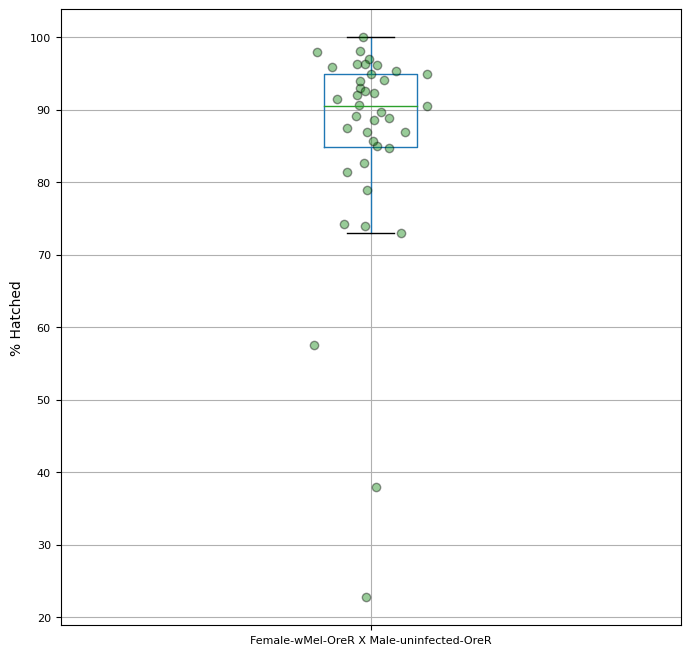

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


class FecundityFriend:
    def __init__ (self, table, graph, infectionStatus=None, graphData=None):
        self.table = table
        self.infectionStatus = infectionStatus
        self.graphData = graphData
    
        self.table['% hatched'] = ((self.table['# hatched larvae (@ ~30 hr)'] / (self.table['# eggs total']))*100).round(2)
        self.table['# eggs / day'] = (self.table['# eggs total'] * (24/self.table['hrs laying'])).round(2)
        self.table['# viable larvae/day'] = (self.table['# hatched larvae (@ ~30 hr)'] * (24/self.table['hrs laying'])).round(2)
        
        FecundityFriend.crossSort(self.table, infectionStatus, graphData, graph)
        
    def crossSort (datatable, infectionStatus, graphData, graph):
        
        if infectionStatus != None:
            uninfCross = []
            uxiInfection = []
            ixuInfection = []
            infCross = []           
            sortedData = datatable.groupby(['experimental infection status', 'control infection status'])
            
            crossTypes = list(sortedData['experimental infection status'].groups.keys())
            
            for cross in crossTypes:
                if cross[0] == ('uninfected' or 'uninf'):
                    if cross[1] == ('uninfected' or 'uninf'):
                        uninfCross.append(cross)
                    else:
                        uxiInfection.append(cross)
                else:
                    if cross[1] == ('uninfected' or 'uninf'):
                        ixuInfection.append(cross)
                    else:
                        infCross.append(cross)
            
            
            if infectionStatus == 'uninfected':
                uninfectedData = sortedData.get_group(uninfCross[0])
                if graph == True:
                    if graphData == None:
                        raise Exception('Please specify data to graph')
                    else:
                        FecundityFriend.graphMaker (uninfectedData, graphData)
                else:
                    display (uninfectedData.head(30))
                        
            elif infectionStatus == 'uxiInfection':
                uxidfs = []
                for item in uxiInfection:
                    df = sortedData.get_group(item)
                    uxidfs.append(df)
                finalUXIDF = pd.concat(uxidfs)
                if graph == True:
                    if graphData == None:
                        raise Exception('Please specify data to graph')
                    else:
                        FecundityFriend.graphMaker (finalUXIDF, graphData)
                else:
                    display (finalUXIDF.head(25))
                    
            elif infectionStatus == 'ixuInfection':
                ixudfs = []
                for item in ixuInfection:
                    df = sortedData.get_group(item)
                    ixudfs.append(df)
                finalIXUDF = pd.concat(ixudfs)
                if graph == True:
                    if graphData == None:
                        raise Exception('Please specify data to graph')
                    else:
                        FecundityFriend.graphMaker (finalIXUDF, graphData)
                else:
                    display (finalIXUDF.head(25))
                        
            elif infectionStatus == 'infected':
                infDFs = []
                for item in infCross:
                    df = sortedData.get_group(item)
                    infDFs.append(df)
                finalINFDF = pd.concat(infDFs)
                if graph == True:
                    if graphData == None:
                        raise Exception ('Please specify data to graph')
                    else:
                        FecundityFriend.graphMaker (finalINFDF, graphData)
                        
                else:
                    display(finalINFDF.head(30))
                        
        
    def graphMaker(groupedData, graphData):
        graphdf = pd.DataFrame()
        finaldf = pd.DataFrame()
        groupedData = groupedData.astype(str)
        graphdf['Experimental Fly'] = groupedData[['experimental sex', 'experimental infection status', 'experimental genotype']].agg('-'.join, axis=1)
        graphdf['Control Fly'] = groupedData[['control sex', 'control infection status', 'control genotype']].agg('-'.join, axis=1)
        graphdf['Cross Name'] = graphdf[['Experimental Fly', 'Control Fly']].agg(' X '.join, axis=1)
        graphdf = graphdf.drop(columns = ['Experimental Fly', 'Control Fly'])
        
        
        if graphData == 'eggCount':
            desiredData = '# eggs total'
            compName = 'Total Eggs'
            desiredDataTitle = 'Avg. Egg Count'
            
        elif graphData == 'hatchRate':
            desiredData = '% hatched'
            compName = '% Hatched'
            desiredDataTitle = 'Avg. Hatch Rate'
            
        graphdf[compName] = groupedData[desiredData]
        if graphData == 'hatchRate':
            graphdf[compName] = graphdf[compName].astype(str).astype(float)
        elif graphData == 'eggCount':
            graphdf[compName] = graphdf[compName].astype(str).astype(int)
        finaldf['Experiment'] = graphdf['Cross Name'].unique()
        finalGroupedData = graphdf.groupby('Cross Name')
        
        
            
        Means = []
        standardError = []
        dfList = []
        for cross in finaldf['Experiment'].unique():
            interimDF = pd.DataFrame()
            crossData = finalGroupedData.get_group(cross)
            interimDF[cross] = crossData[compName]
            dfList.append(interimDF)
            Means.append(crossData[compName].mean().round(2))
            standardError.append(crossData[compName].std())
        
        graphDF = pd.concat(dfList, ignore_index = True)
        graphDF.boxplot(figsize = (8,8), fontsize = 8, showfliers = False).set_ylabel(compName)
        for i, d in enumerate(graphDF):
            y= graphDF[d]
            x = np.random.normal(i+1, 0.04, len(y))
            plt.plot(x, y, mfc = ['green','blue','red', 'pink'][i], mec='k', ms=6, marker="o", linestyle="None", alpha = 0.4)
        
        finaldf[desiredDataTitle] = Means
        finaldf['Standard Deviation'] = standardError
        display (finaldf)
        plt.show()

        


class CommandLine() :
    '''
    Handle the command line, usage and help requests.

    CommandLine uses argparse, now standard in 2.7 and beyond. 
    it implements a standard command line argument parser with various argument options,
    a standard usage and help.

    attributes:
    all arguments received from the commandline using .add_argument will be
    avalable within the .args attribute of object instantiated from CommandLine.
    For example, if myCommandLine is an object of the class, and requiredbool was
    set as an option using add_argument, then myCommandLine.args.requiredbool will
    name that option.
 
    Modified from BME 160 Lab 5 By Rexton Lynn
    '''
    
    def __init__(self, inOpts=None) :
        '''
        Implement a parser to interpret the command line argv string using argparse.
        '''
        
        import argparse
        self.parser = argparse.ArgumentParser(description = 'Takes input file (.tsv) of spreadsheet and graphs data according to args', 
                                             epilog = 'Data must include egg count, hatch count, infection status for male and female to work properly', 
                                             add_help = True, #default is True 
                                             prefix_chars = '-', 
                                             usage = '%(prog)s [options] -option1[default] <input >output'
                                             )
        self.parser.add_argument('-mE', '--minEgg', action = 'store', nargs='?', default=20, help='Include data only above this egg count')
        self.parser.add_argument('-g', '--graph', action = 'store', nargs = '?', const=True, default=False, help='Graph data if called (dependent on -gD and -iS args)')
        self.parser.add_argument('-iS', '--infectionStatus', action = 'store', choices=('infected', 'uninfected', 'uxiInfection', 'ixuInfection'), nargs='?', help='Select data based on infection status')
        self.parser.add_argument('-gD', '--graphData', action = 'store', choices = ('eggCount', 'hatchRate'), nargs='?', default=None, help='Specify which type of data to graph')
        self.parser.add_argument('-mA', '--minAge', action = 'store', nargs='?', default=0, help='Min age of experimental flies for data')
        self.parser.add_argument('-MA', '--maxAge', action = 'store', nargs='?', default=10, help='Max age of experimental flies for data')
        self.parser.add_argument('-v', '--version', action='version', version='%(prog)s 0.9')  
        if inOpts is None :
            self.args = self.parser.parse_args()
        else :
            self.args = self.parser.parse_args(inOpts)


def main (filename=None, options=None):
    data = pd.read_csv(filename, engine='python', sep='\t')
    thisData = CommandLine(options)
    print (thisData.args)
    requiredInfo = ['hrs laying', 'hrs hatching', 'experimental sex', 'control sex', '# eggs total', '# hatched larvae (@ ~30 hr)', 
'#cross start date (including: plate->replate->count->count)', 'experimental genotype',
'control genotype', 'control age (days; +1 = lay age)', 'experimental infection status', 'control infection status', 'experimental age (days; +1 = lay age) ']
    
    filteredData = data[data['# eggs total'] >= thisData.args.minEgg].dropna(subset = requiredInfo)
    filteredData['experimental age (days; +1 = lay age) '] = pd.to_numeric(filteredData['experimental age (days; +1 = lay age) '])
    filteredData = filteredData[(filteredData['experimental age (days; +1 = lay age) '] >= thisData.args.minAge)]
    filteredData = filteredData[(filteredData['experimental age (days; +1 = lay age) '] <= thisData.args.maxAge)]
    if filteredData.empty:
        raise Exception('No Data Found! Please adjust age settings')
    testData = pd.DataFrame(filteredData[requiredInfo], columns=filteredData.columns)
    #display (testData.head(25))
    
    fecundityData = FecundityFriend(testData, thisData.args.graph, thisData.args.infectionStatus, thisData.args.graphData)
    

if __name__ == "__main__":
    main(filename = 'Table_S1_fecundity_assays - CI.noNAs.tsv', options = ['-g','-iS=ixuInfection', '-gD=hatchRate'])